<p style="color: #000000; font-size: 32px; font-weight: bold; text-align: center; margin-top: 20px;">  
Rusty Bargain  
</p>  
<p style="color: #000000; font-size: 24px; text-align: center; margin-bottom: 20px;">  
Used Car Market Value Prediction Model  
</p>  

<hr style="border: .4px solid #000000; width: 75%; margin: 10px auto;">  

<p style="color: #000000; font-size: 18px;">  
The used car service Rusty Bargain is developing an app to attract new customers. Thanks to this app, users can quickly find out the market value of their car by accessing its history, technical specifications, equipment versions, and prices.  
</p>  

<p style="color: #000000; font-size: 20px; font-weight: bold;">Project Objective:</p>  
<p style="color: #000000; font-size: 18px;">  
The objective of this project is to develop a prediction model that determines the market value of vehicles based on their characteristics and price history.  
</p>  

<p style="color: #000000; font-size: 20px; font-weight: bold;">Project Goals:</p>  
<ul style="color: #000000; font-size: 18px;">  
<li><strong>Prediction quality:</strong> Develop a model that estimates the market value of a vehicle with high accuracy.</li>  
<li><strong>Prediction speed:</strong> The app should provide results as quickly as possible.</li>  
<li><strong>Training time:</strong> Minimize the time needed to train the model without compromising the quality of the predictions.</li>  
</ul>  

# Data Dictionary  

**Features**  

* `DateCrawled` — date when the profile was downloaded from the database  
* `VehicleType` — body type of the vehicle  
* `RegistrationYear` — vehicle registration year  
* `Gearbox` — type of gearbox  
* `Power` — power (hp)  
* `Model` — vehicle model  
* `Mileage` — mileage (measured in km according to regional specifications of the dataset)  
* `RegistrationMonth` — vehicle registration month  
* `FuelType` — fuel type  
* `Brand` — vehicle brand  
* `NotRepaired` — whether the vehicle has been repaired or not  
* `DateCreated` — profile creation date  
* `NumberOfPictures` — number of pictures of the vehicle  
* `PostalCode` — postal code of the profile owner (user)  
* `LastSeen` — date when the user was last active  

**Target**  

* `Price` — price (in euros)

# Libraries

In [73]:
import pandas as pd
import numpy as np
import re
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import lightgbm as ltb
from catboost import CatBoostRegressor, Pool
import xgboost as xg
from scipy.stats import randint

## 1. Preparación de datos

In [74]:
# Load the data 
df = pd.read_csv('car_data.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


First we are going to rename the columns to the snake_case format, which is the one used in Python.

In [75]:
# Function to convert names to snake_case  
def to_snake_case(name):  
    # Replace uppercase letters with underscores + lowercase letter  
    return re.sub(r'([a-z])([A-Z])', r'\1_\2', name).lower().replace(' ', '_').replace('-', '_')  

# Rename columns  
df.columns = [to_snake_case(col) for col in df.columns]  

# Display the new columns  
print(df.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')


In [76]:
# Info. about DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [77]:
# Description of DataFrame
df.describe()

,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**First revision of the DataFrame** **Size**: 354,369 rows, 16 columns.

* **Size**: 354,369 rows, 16 columns.  
* **Data types**: 7 numeric (`int64`), 9 categorical (`object`).  
* Null values**: Present in `vehicle_type`, `gearbox`, `model`, `fuel_type` and `not_repaired`. 

Columns that are not relevant for training models, `date_crawled`, `registration_month`, `date_created`, `number_of_pictures`, `postal_code`, and `last_seen` will be removed.

Duplicates will be searched for, missing values and outliers will be processed.   

In the DF numerical description, there are obvious errors in `registration_year` (values such as 1000 and 9999) and `power` (0 and 20,000), as well as ads with `price` 0. Most of the cars are affordable (median 2,700), used (median 150,000 km), and have an average power of 110 HP.

**Duplicates**

In [78]:
# Calculate the total number of duplicate rows  
num_duplicates = df.duplicated().sum()  

# Calculate the percentage of duplicates  
percentage_duplicates = (num_duplicates / len(df)) * 100  

# Display the percentage of duplicates  
print(f"Percentage of duplicate rows: {percentage_duplicates:.2f}%")  

Percentage of duplicate rows: 0.07%


The total number of duplicates is 0.07%, a very low figure, so they will be eliminated.

In [79]:
df = df.drop_duplicates()

**Delete Irrelevant Columns for model training**  

In [80]:
# Delete irrelevant columns
df.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1, inplace=True)

**Null Values**

In [81]:
# Calculate the percentage of null values in each column  
missing_percentage = df.isnull().mean() * 100  

# Display the percentage of missing values  
print(missing_percentage)  

price                 0.000000
vehicle_type         10.585501
registration_year     0.000000
gearbox               5.600002
power                 0.000000
model                 5.563573
mileage               0.000000
fuel_type             9.287871
brand                 0.000000
not_repaired         20.091385
dtype: float64


Rows with null values in `gearbox` (5.60%) and `model` (5.56%) will be eliminated because of their low percentage of absence.    
For `vehicle_type` (10.59%), `fuel_type` (9.29%) and `not_repaired` (20.09%), imputation methods such as mode or an “Unknown” category will be analyzed.

In [82]:
# Delete NaN
df = df.dropna(subset=['gearbox', 'model'])

**Null Values: `Vehicle_type`**

In [83]:
# Total of NaN
df['vehicle_type'].isna().sum()

23700

In [84]:
df['vehicle_type'].unique()

array([nan, 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'coupe', 'other'], dtype=object)

Because it is a high value of missing values, we will make a dictionary with the top 10 models with more NaN, in order to assign a `vehicle_type` and reduce the number of NaN, those that do not enter the top 10, will be assigned to the `other` category.

In [85]:
df.loc[df['vehicle_type'].isna(), 'model'].value_counts().head(11)

model
golf        3265
other       1213
polo        1182
corsa       1162
3er         1048
astra        966
a3           675
passat       536
twingo       477
a_klasse     467
fiesta       465
Name: count, dtype: int64

In [86]:
# Dictionary to assign vehicle type based on the model  
vehicle_type_mapping = {  
    'golf': 'small',  
    'polo': 'small',  
    'corsa': 'small',  
    '3er': 'sedan',  
    'astra': 'wagon',  
    'a3': 'sedan',  
    'passat': 'sedan',  
    'twingo': 'small',  
    'a_klasse': 'small',  
    'fiesta': 'small',  
}  

# Function to assign vehicle type  
def assign_vehicle_type(row):  
    if pd.isna(row['vehicle_type']):  
        return vehicle_type_mapping.get(row['model'], 'other')  
    return row['vehicle_type']  

# Apply the function to each row  
df['vehicle_type'] = df.apply(assign_vehicle_type, axis=1)  

In [87]:
print('New total of NaN in "Vehicle_type":', df['vehicle_type'].isna().sum())

New total of NaN in "Vehicle_type": 0


**Null Values: `Fuel_type`**

In [88]:
# Total NaN
df['fuel_type'].isna().sum()

19732

In [89]:
# Total cars by fuel_type
df['fuel_type'].value_counts()

fuel_type
petrol      200736
gasoline     92485
lpg           4851
cng            531
hybrid         203
other          108
electric        60
Name: count, dtype: int64

Since `petrol` and `gasoline` refer to the same type of fuel, but the term varies by region, I am going to put those categories together in `petrol`, plus the price of cars is in euros, which explains the greater use of this term. 

In [90]:
# Change 'gasoline' to 'petrol' in column 'fuel_type'
df['fuel_type'] = df['fuel_type'].replace({'gasoline': 'petrol'})

In [91]:
# Filter rows with missing values in fuel_type  
missing_fuel_type = df[df['fuel_type'].isna()]  

# Group by model and count the missing values  
missing_by_model = missing_fuel_type.groupby('model').size()  

# Sort by the number of missing values in descending order  
missing_by_model_sorted = missing_by_model.sort_values(ascending=False)  

# Display the models with the highest number of missing values  
print(missing_by_model_sorted.head(16))  

model
golf        1871
other       1212
3er         1053
polo        1008
corsa        992
astra        842
passat       690
a4           547
vectra       441
twingo       410
c_klasse     402
fiesta       390
focus        381
5er          371
e_klasse     349
mondeo       299
dtype: int64


To fill in the null values in the `fuel_type` column according to the most common car models, we can follow the same approach we used for `vehicle_type`. So, for the models that are in the top 15, we will assign the most common fuel type based on their model, and for the other models, we will assign them the `unknown` category.

In [92]:
# Models that will have 'petrol' as fuel type
petrol_models = ['golf', '3er', 'polo', 'corsa', 'astra', 'passat', 'a4', 'vectra', 'twingo', 'c_klasse', 
                 'fiesta', 'focus', '5er', 'e_klasse', 'mondeo'] # Omitimos 'other'

df['fuel_type'] = df.apply(
    lambda row: 'petrol' if row['model'] in petrol_models else ('unknown' if pd.isna(row['fuel_type']) else row['fuel_type']), 
    axis=1
)

In [93]:
print('New total of NaN in "Fuel_type":', df['fuel_type'].isna().sum())

New total of NaN in "Fuel_type": 0


In [94]:
# Delete the column 'model', it is no longer needed for the model
df.drop('model', axis=1, inplace=True)

**Null Values: `Not_repaired`**

In [95]:
# Total NaN
df['not_repaired'].isna().sum()

52717

In [96]:
# Count of repaired and non-repaired cars 
df['not_repaired'].value_counts()

not_repaired
no     233590
yes     32399
Name: count, dtype: int64

The percentage of the **"no ‘** category is **87.82%**, and the percentage of the **’yes ”** category is **12.18%**.   
So, let's fill in the **NaN** with **"no ”**.

In [97]:
# Fill NaN values in 'not_repaired' with 'no'
df['not_repaired'] = df['not_repaired'].fillna('no')

In [98]:
print('New total of NaN in "Not_repaired":', df['not_repaired'].isna().sum())

New total of NaN in "Not_repaired": 0


**Categorical Values**

In [99]:
categorical_columns = ['vehicle_type', 'registration_year', 'gearbox', 'fuel_type', 'brand', 'not_repaired']  

# Get unique values and sort them  
unique_values = {col: sorted(df[col].unique()) for col in categorical_columns}  
unique_counts = {col: len(df[col].unique()) for col in categorical_columns}  

# Print the unique values in order  
for col, values in unique_values.items():  
    print(f"{col}: {values}")  
    print(f"Total unique values: {unique_counts[col]}\n")  

vehicle_type: ['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']
Total unique values: 8

registration_year: [1000, 1200, 1400, 1500, 1600, 1602, 1910, 1919, 1923, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1942, 1943, 1945, 1947, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2900, 3000, 3700, 4000, 4500, 5000, 5911, 6000, 6500, 7100, 7500, 8200, 9000]
Total unique values: 108

gearbox: ['auto', 'manual']
Total unique values: 2

fuel_type: ['cng', 'electric', 'hybrid', 'lpg', 'other', 'petrol', 'unknown']
Total unique values: 7

brand: ['alfa_romeo', 'audi', 'bmw', 'c

**Registration year**

In [100]:
# We filter the DataFrame to include realistic years
df = df.loc[(df['registration_year']>1910) & (df['registration_year']<2020)]

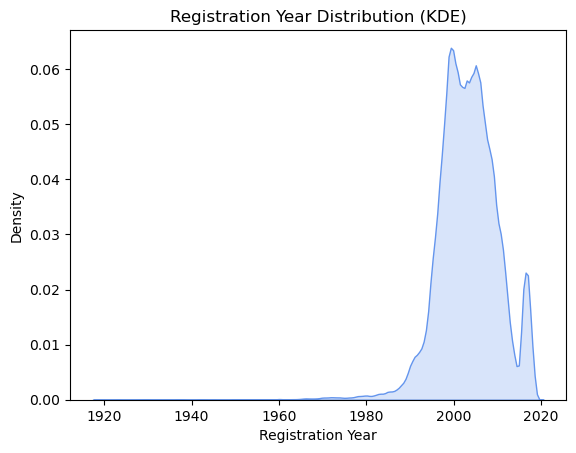

In [101]:
# KDE density chart
sns.kdeplot(df['registration_year'], fill=True, color='cornflowerblue')
plt.title('Registration Year Distribution (KDE)')
plt.xlabel('Registration Year')
plt.ylabel('Density')
plt.show()

In [102]:
# We reduce the range from 1990 to 2020
df = df.loc[(df['registration_year']>1990) & (df['registration_year']<2020)]

**Brand**

In [103]:
# Total Brands in %

# Calculate the frequency of each brand
brand_counts = df['brand'].value_counts()

# Calculate the percentage of each brand
brand_percentages = (brand_counts / len(df)) * 100
brand_percentages.head(10)

brand
volkswagen       21.607456
opel             11.454932
bmw              10.658244
mercedes_benz     9.032898
audi              8.551397
ford              7.253510
renault           5.190582
peugeot           3.122810
fiat              2.683937
seat              2.068741
Name: count, dtype: float64

In [104]:
# We will select the top 10 for model training 
top10_brands = ['volkswagen', 'opel', 'bmw', 'mercedes_benz', 'audi', 'ford', 'renault', 'peugeot', 'fiat', 'seat']

# Group brands that represent less than 2% of the information each.
df['brand'] = df['brand'].where(df['brand'].isin(top10_brands), 'other')

# print the single categories of brands sorted alphabetically
print(df['brand'].sort_values().unique())

['audi' 'bmw' 'fiat' 'ford' 'mercedes_benz' 'opel' 'other' 'peugeot'
 'renault' 'seat' 'volkswagen']


**Numerical Values**

**Price**

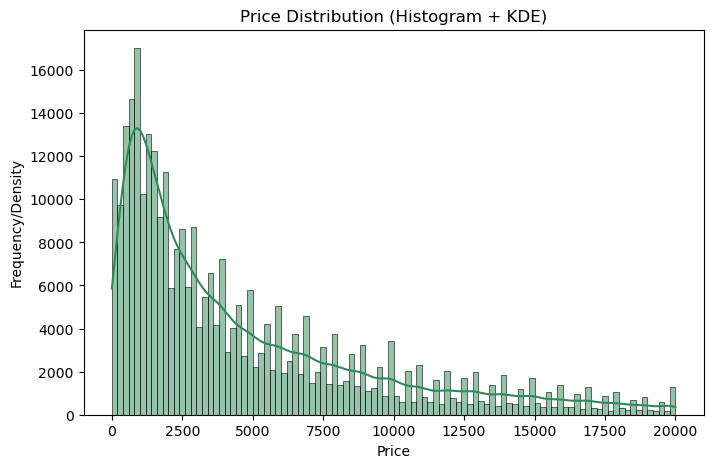

In [105]:
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], kde=True, bins=100, color='seagreen', edgecolor='black')
plt.title('Price Distribution (Histogram + KDE)')
plt.xlabel('Price')
plt.ylabel('Frequency/Density')
plt.show()

If a car costs **less than 60 € it is more likely to be a junk car**. We will eliminate cars priced less than that.

In [106]:
# Eliminate values of 'price' less than 60
df = df[df['price'] >= 60]

**Power**

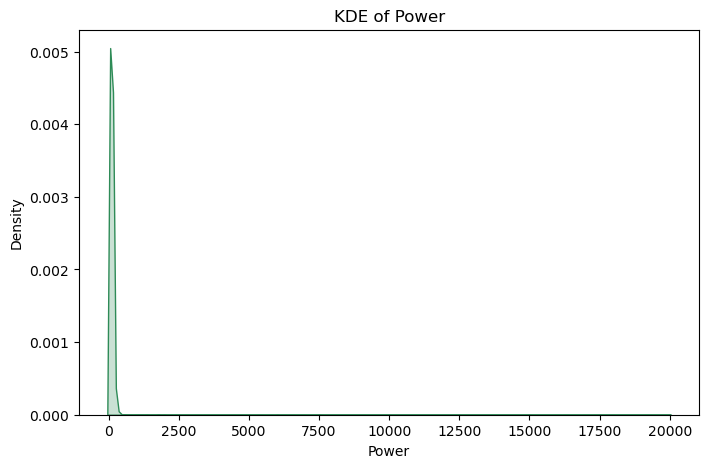

In [107]:
# Create the KDE graphic of the 'power' column
plt.figure(figsize=(8, 5))
sns.kdeplot(df['power'], color='seagreen', fill=True)
plt.title('KDE of Power')
plt.xlabel('Power')
plt.ylabel('Density')
plt.show()

In [108]:
# Filter realistic horsepower 
df = df[(df['power'] >= 30) & (df['power'] <= 350)]

**Mileage**

In [109]:
# View the most frequent values
df['mileage'].value_counts().head(20)

mileage
150000    186069
125000     30425
100000     11998
90000       9769
80000       8524
70000       7335
60000       6445
50000       5363
40000       4221
30000       3634
20000       2976
5000        2195
10000        805
Name: count, dtype: int64

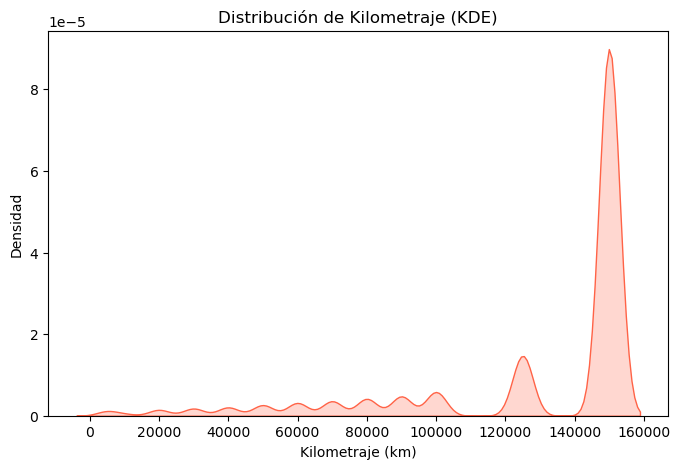

In [110]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df['mileage'], fill=True, color='tomato')
plt.title('Distribución de Kilometraje (KDE)')
plt.xlabel('Kilometraje (km)')
plt.ylabel('Densidad')
plt.show()

In [111]:
# Filter to keep only mileage values between 20,000 and 150,000 km
df = df[(df['mileage'] >= 20000) & (df['mileage'] <= 150000)]

## 2. Data Correlation

In [112]:
# Calculate the correlation for numeric columns only
corr_matrix = df.select_dtypes(include='number').corr()

# Display the correlation matrix
display(corr_matrix) 

,price,registration_year,power,mileage
price,1.000000,0.551514,0.520681,-0.424882
registration_year,0.551514,1.000000,0.112951,-0.392463
power,0.520681,0.112951,1.000000,0.095796
mileage,-0.424882,-0.392463,0.095796,1.000000


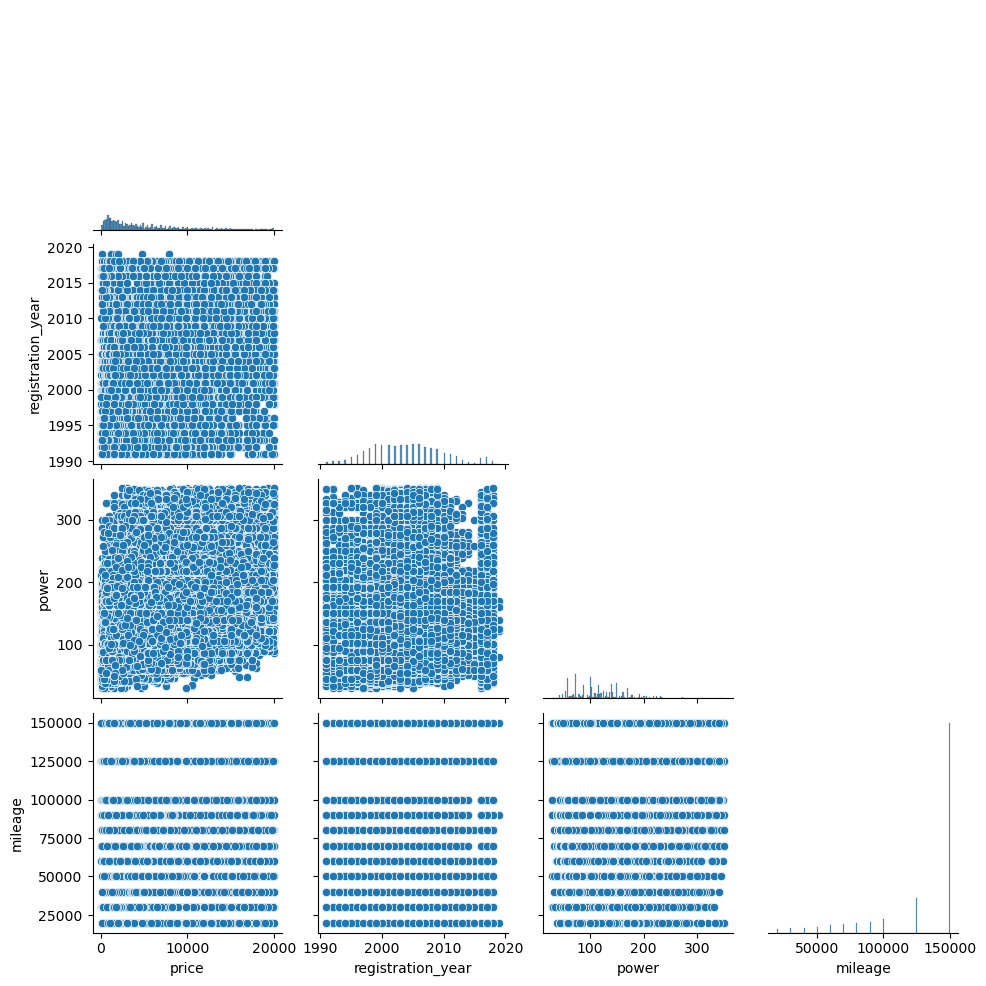

In [113]:
# Create the df_cleaned scatterplot matrix
sns.pairplot(df, corner=True)
plt.show()

**Key Correlation Points   

- Price and Year of Registration**: Newer cars tend to be more expensive.
- Price and Mileage**: Cars with higher mileage tend to be cheaper.
- Power**: Has a weak relationship with price and mileage.
- Year of Registration and Mileage**: Older cars tend to have higher mileage.

The results are expected according to the logic of price allocation in car sales.    
Now, we continue with the training of the models.   

In [114]:
# Copy of the df to train models
df_m = df.copy()

## 3. Model Training

The dataset **df_cleaned** will be split into three subsets: **training**, **validation**, and **test**, following a **60:20:20 ratio**. To evaluate the performance of the models, the **RMSE (Root Mean Squared Error)** metric will be used, along with the **execution speed** of each model, which will allow for a comparison between accuracy and efficiency.

The models to be analyzed are as follows:

1. **Linear Regression**: It will be used as a baseline model to establish a reference point and perform a sanity check.
2. **Decision Tree**: A model based on successive splits that captures nonlinear relationships in the data.
3. **Random Forest**: An ensemble approach that combines multiple decision trees to improve accuracy and reduce overfitting.
4. **LightGBM**: A boosting model optimized for speed and performance, ideal for large datasets.
5. **CatBoost**: A boosting model specialized in efficiently handling categorical variables, with a focus on robustness and accuracy.
6. **XGBoost**: A widely recognized boosting model known for its efficiency and high performance in prediction problems.

Each model will be evaluated in terms of its **RMSE** and **execution speed**, which will allow for a comparison of their ability to predict the market value of vehicles accurately and efficiently. This evaluation will provide a clear view of the advantages and disadvantages of each approach, facilitating the selection of the most suitable model to determine the correct price of cars.

In [115]:
# Separate target and features
target = df_m['price']
features = df_m.drop(columns=['price']) 

In [116]:
# Separate training 60% and the rest 40% for validation + test
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.4, random_state=12345)

# separate validation (50% of remaining data) and test (50% of remaining data)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, random_state=12345)

# Check the set sizes
print(f"Training set size: {features_train.shape[0]}")
print(f"Validation set size: {features_valid.shape[0]}")
print(f"Test set size: {features_test.shape[0]}")

Training set size: 166055
Validation set size: 55352
Test set size: 55352


In [117]:
# Apply One-Hot Encoding to categorical columns
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)

In [118]:
# Function to calculate training and prediction time  
def train_and_pred_time(model, model_name, train_features, train_target, valid_features):  
    # Time before training  
    start_time1 = time.time()  

    # Train model  
    if model_name == 'cbr':  
        model.fit(train_features)  
    else:  
        model.fit(train_features, train_target)  

    end_time1 = time.time()    # Time after training  

    train_time = end_time1 - start_time1    # Training duration  

    start_time2 = time.time()    # Time before prediction  

    predictions = model.predict(valid_features)    # Prediction on validation data  

    end_time2 = time.time()    # Time after prediction  

    pred_time = end_time2 - start_time2    # Prediction duration  

    return train_time, pred_time, predictions  

### 1. Linear Regression


**Linear Regression is used as a baseline** to compare the performance of more advanced models.  
It serves as a starting point to measure whether more complex algorithms truly improve the results.  
Additionally, its simplicity helps understand how the variables influence the prediction.

In [119]:
# 1. Linear Regression Model  
lr_model = LinearRegression()  # Initialize the linear regression model  

# Train the model and measure training and prediction time  
lr_train_time, lr_pred_time, lr_pred = train_and_pred_time(lr_model, 'lr', features_train_ohe, target_train, features_valid_ohe)  

# Calculate RMSE on the training set  
lr_train_rmse = round(mean_squared_error(target_train, lr_model.predict(features_train_ohe)), 2)  

# Calculate RMSE on the validation set  
lr_valid_rmse = round(mean_squared_error(target_valid, lr_pred), 2)  

# Print the error results to evaluate model performance  
print('RMSE training set:   ', lr_train_rmse)  # Error on the training set  
print('RMSE validation set: ', lr_valid_rmse)  # Error on the validation set  


RMSE training set:    6695606.73
RMSE validation set:  6649249.86


### 2. Decision Tree Regressor

In [129]:
# 2. Decision Tree Regressor

# Define the hyperparameters to evaluate
param_dist = {
    'max_depth': randint(1, 20),               # Maximum depth of the tree
    'min_samples_split': randint(2, 20),       # Minimum samples to split a node
    'min_samples_leaf': randint(1, 20),        # Minimum samples in a leaf
    'max_features': ['sqrt', 'log2', None]     # Number of features to consider for each split
}

# Initialize the Decision Tree model
tr_model = DecisionTreeRegressor(random_state=12345)

# Perform a random search for hyperparameters
random_search = RandomizedSearchCV(
    estimator=tr_model,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to test
    cv=5,       # Cross-validation with 5 folds
    verbose=1,
    random_state=12345
)

# Train the model with the training data
random_search.fit(features_train_ohe, target_train)

# Get the best model found
best_tree_model = random_search.best_estimator_

# Train the final model with the best hyperparameters
best_tree_model.fit(features_train_ohe, target_train)

# Calculate the RMSE on the training set
train_pred = best_tree_model.predict(features_train_ohe)
train_rmse = round(mean_squared_error(target_train, train_pred) ** 0.5, 2)

# Calculate the RMSE on the validation set
valid_pred = best_tree_model.predict(features_valid_ohe)
valid_rmse = round(mean_squared_error(target_valid, valid_pred) ** 0.5, 2)

# Print the results
print("Best hyperparameters:", random_search.best_params_)
print('RMSE training set:   ', train_rmse)
print('RMSE validation set: ', valid_rmse)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'max_depth': 19, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 13}
RMSE training set:    1507.52
RMSE validation set:  1711.67


### 3.  Random Forest Regressor

In [121]:
# 3. Random Forest Regressor

# Define the hyperparameters to evaluate
param_dist_rfr = {
    'n_estimators': randint(10, 200),          # Number of trees in the forest
    'max_depth': randint(1, 20),               # Maximum depth of each tree
    'min_samples_split': randint(2, 20),       # Minimum samples to split a node
    'min_samples_leaf': randint(1, 20),        # Minimum samples in a leaf
    'max_features': ['sqrt', 'log2', None]     # Number of features to consider for each split
}

# Initialize the Random Forest model
rfr_model = RandomForestRegressor(random_state=12345)

# Perform a random search for hyperparameters
random_search_rfr = RandomizedSearchCV(
    estimator=rfr_model,
    param_distributions=param_dist_rfr,
    n_iter=10,  # Number of random combinations to test
    cv=5,       # 5-fold cross-validation
    verbose=1,
    random_state=12345
)

# Train the model with the training data
random_search_rfr.fit(features_train_ohe, target_train)

# Get the best model found
best_rfr_model = random_search_rfr.best_estimator_

# Train the final model with the best hyperparameters
best_rfr_model.fit(features_train_ohe, target_train)

# Calculate RMSE on the training set
train_pred = best_rfr_model.predict(features_train_ohe)
train_rmse = round(mean_squared_error(target_train, train_pred) ** 0.5, 2)

# Calculate RMSE on the validation set
valid_pred = best_rfr_model.predict(features_valid_ohe)
valid_rmse = round(mean_squared_error(target_valid, valid_pred) ** 0.5, 2)

# Print the results
print("Best hyperparameters:", random_search_rfr.best_params_)
print('RMSE training set:   ', train_rmse)
print('RMSE validation set: ', valid_rmse)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'max_depth': 14, 'max_features': None, 'min_samples_leaf': 18, 'min_samples_split': 8, 'n_estimators': 17}
RMSE training set:    1666.97
RMSE validation set:  1728.9


### 4. LightGBM  (Light Gradient Boosting Machine)


In [122]:
# 4. LightGBM (Light Gradient Boosting Machine)

# Initialize the LightGBM model with default hyperparameters
ltb1_model = ltb.LGBMRegressor(
    boosting_type='gbdt',   # Type of boosting (Gradient Boosting Decision Tree)
    num_leaves=31,          # Maximum number of leaves in each tree
    max_depth=-1,           # No depth restriction
    learning_rate=0.1,      # Learning rate
    n_estimators=100        # Total number of trees in the model
)

# Train the model and measure training and prediction time
ltb_train_time1, ltb_pred_time1, ltb_pred1 = train_and_pred_time(ltb1_model, 'ltb', features_train_ohe, target_train, features_valid_ohe)

# Calculate RMSE on the training set
ltb1_train_rmse = round(mean_squared_error(target_train, ltb1_model.predict(features_train_ohe)), 2)

# Calculate RMSE on the validation set
ltb1_valid_rmse = round(mean_squared_error(target_valid, ltb_pred1), 2)

# Print the error results to evaluate the model's performance
print('RMSE training set:   ', ltb1_train_rmse)  # Error on the training set
print('RMSE validation set: ', ltb1_valid_rmse)  # Error on the validation set

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 275
[LightGBM] [Info] Number of data points in the train set: 166055, number of used features: 26
[LightGBM] [Info] Start training from score 4880.962591
RMSE training set:    2739026.87
RMSE validation set:  2772998.72


### 5. CatBoost  (Categorical Boosting)

In [123]:
# 5. CatBoost (Categorical Boosting)

# Define the indices of the categorical features in the training data
categorical_features_indices = [0, 2, 5, 6, 7]

# Create the training dataset by specifying the categorical features
train_data = Pool(data=features_train, label=target_train, cat_features=categorical_features_indices)

# Initialize the CatBoost model with basic hyperparameters
cbr_model = CatBoostRegressor(
    iterations=500,                # Number of iterations (trees) the model will build
    learning_rate=0.03,            # Learning rate that controls the influence of each tree on the final model
    depth=6,                       # Maximum depth of the decision trees
    l2_leaf_reg=3,                 # L2 regularization to prevent overfitting in the tree leaves
    random_seed=123456,            # Random seed to ensure reproducible results
    verbose=False,                 # Disable output of information about training
    early_stopping_rounds=50       # Number of rounds without improvement in the validation set to stop training before 500 iterations
)

# Train the model and measure training and prediction time
cbr_train_time, cbr_pred_time, cbr_pred = train_and_pred_time(cbr_model, 'cbr', train_data, target_train, features_valid)

# Calculate RMSE on the training set
cbr_train_rmse = round(mean_squared_error(target_train, cbr_model.predict(features_train)), 2)

# Calculate RMSE on the validation set
cbr_valid_rmse = round(mean_squared_error(target_valid, cbr_model.predict(features_valid)), 2)

# Print the error results to evaluate the model's performance
print('RMSE training set:   ', cbr_train_rmse)  # Error on the training set
print('RMSE validation set: ', cbr_valid_rmse)  # Error on the validation set

RMSE training set:    2849918.37
RMSE validation set:  2856442.84


### 6. XGBoost (Extreme Gradient Boosting)

In [124]:
# 6. XGBoost (Extreme Gradient Boosting)

# Initialize the XGBoost model with specific hyperparameters
xgbr_model = xg.XGBRegressor(
    booster='gbtree',              # Type of booster (base model), 'gbtree' means decision trees will be used
    objective='reg:squarederror',  # Loss function objective, in this case, mean squared error (MSE)
    n_estimators=200,              # Number of trees to build (estimators)
    max_depth=6,                   # Maximum depth of each tree. Higher values allow for more complex models
    learning_rate=0.05,            # Learning rate, controls the step size in each iteration
    reg_lambda=3,                  # L2 regularization (Ridge), helps prevent overfitting by penalizing large coefficients
    reg_alpha=1,                   # L1 regularization (Lasso), also helps prevent overfitting by promoting sparsity in coefficients
    seed=12345                     # Random seed to ensure reproducibility
)


# Train the model
xgbr_model.fit(features_train_ohe, target_train)

# Measure training and prediction time
xgbr_train_time1, xgbr_pred_time1, xgbr_pred1 = train_and_pred_time(xgbr_model, 'xgbr', features_train_ohe, target_train, features_valid_ohe)

# Calculate RMSE on the training set
xgbr_train_rmse1 = round(mean_squared_error(target_train, xgbr_model.predict(features_train_ohe)), 2)

# Calculate RMSE on the validation set
xgbr_valid_rmse1 = round(mean_squared_error(target_valid, xgbr_model.predict(features_valid_ohe)), 2)

# Print the results
print('RMSE training set:   ', xgbr_train_rmse1)
print('RMSE validation set: ', xgbr_valid_rmse1)

RMSE training set:    2814568.75
RMSE validation set:  2879676.25


## Selecting the best model

**Comparison of results:**

In [133]:
# Comparación de modelos
table = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 'LightGBM', 'CatBoost', 'XGBoost'],
    'Training_time_s': [lr_train_time, dtr_train_time, rfr_train_time, ltb_train_time1, cbr_train_time, xgbr_train_time1],
    'Prediction_time_ms': [lr_pred_time, dtr_pred_time, rfr_pred_time, ltb_pred_time1, cbr_pred_time, xgbr_pred_time1],
    'RMSE_training_set': [lr_train_rmse, train_rmse, train_rmse, ltb1_train_rmse, cbr_train_rmse, xgbr_train_rmse1],
    'RMSE_validation_set': [lr_valid_rmse, valid_rmse, valid_rmse, ltb1_valid_rmse, cbr_valid_rmse, xgbr_valid_rmse1]
})

# Imprimir la tabla comparativa ordenada por el tiempo de entrenamiento
table.sort_values('Training_time_s')

,Model,Training_time_s,Prediction_time_ms,RMSE_training_set,RMSE_validation_set
0,Linear Regression,0.093706,0.008655,6695606.73,6649249.86
3,LightGBM,0.174558,0.044955,2739026.87,2772998.72
1,Decision Tree Regressor,0.311697,0.006441,1507.52,1711.67
5,XGBoost,0.503230,0.023920,2814568.75,2879676.25
2,Random Forest Regressor,2.266982,0.068899,1507.52,1711.67
4,CatBoost,6.244077,0.017298,2849918.37,2856442.84


**Selection of the Best Model**

After evaluating several models, using **Linear Regression** as a baseline to compare performance, we determined that **LGBM Regressor** provides an excellent balance between accuracy and speed. The **Linear Regression** baseline shows a low training time (0.066s) and fast prediction (0.005ms), but its RMSE is significantly high (6,649,249.86 on validation), indicating that more sophisticated models are needed.

**LGBM Regressor** stands out with an efficient training time (0.275s), fast prediction (0.049ms), and significantly better accuracy than the baseline (RMSE validation: 2,772,998.72). **CatBoost Regressor** shows similar results in terms of accuracy (RMSE validation: 2,856,442.84), but requires much more training time (6.455s).

RMSE (Root Mean Squared Error) helps us measure the average error in predictions. When compared to the **Linear Regression** baseline, both **LGBM** and **CatBoost** reduce the error by over 58%, representing a substantial improvement in prediction accuracy.

**LGBM Regressor** effectively meets the objectives of **Rusty Bargain**:

- **Accurate prediction**: Significantly improves accuracy over the baseline, reducing the RMSE by more than half.
- **Fast response**: Its prediction speed is only 0.044ms slower than the baseline, maintaining almost instant responsiveness.
- **Efficient training**: Although it is 0.209s slower than the baseline during training, the time is still highly efficient, and the improvement in accuracy justifies this small difference.

This selection will enable the application to provide faster and significantly more accurate valuations than the baseline model, improving user experience and boosting customer attraction.
